In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, inv

# %% Options
np.set_printoptions(linewidth=160)

# %% Functions


def makeA2D(nx: int, ny: int, sigma: float):
    """Make block matrix A and b. (First make A = dia(A_d), then add A_u and A_l
       to A. Furthermore, correct each diagonal block boundaries and corners in 
       interior of A. Lastly fix two points.) (Made under assumption that rowsum
       of A,B must be 1.)

    Args:
        nx (int): # points in x
        ny (int): # points in y
        sigma (float): Coefficient (dt*D/(2dxdy))

    Returns:
        A, B: Block matrix A and B
    """

    # A (nxny,nxny) (Using A_d for the entire block first, then correct)
    offset = [-nx, -1, 0, 1, nx]  # Offset includes A_+-1
    valsA = [-sigma, -sigma, (1+4)*sigma, -sigma, -sigma]
    valsB = [sigma, sigma, (1-4)*sigma, sigma, sigma]
    A_dia = diags(valsA, offset, (nx*ny, nx*ny))  # guess this is right shape
    B_dia = diags(valsB, offset, (nx*ny, nx*ny))  # guess this is right shape

    # A_u (nx,nx) (Corrects upper left and lover right block of A)
    offsetU = [-1, 0, 1]
    valsUA = [-sigma, 1+3*sigma, -sigma]
    valsUB = [sigma, 1-3*sigma, sigma]
    Au_dia = diags(valsUA, offsetU, (nx, nx))
    Bu_dia = diags(valsUB, offsetU, (nx, nx))

    # Convert to modifiable matrix type and modify
    A = csr_matrix(A_dia)
    Au = csr_matrix(Au_dia)
    B = csr_matrix(B_dia)
    Bu = csr_matrix(Bu_dia)

    Au[0,0] = 1+2*sigma
    Au[nx-1,nx-1] = 1+2*sigma
    Bu[0,0] = 1-2*sigma
    Bu[nx-1,nx-1] = 1-2*sigma
    

    # Fix left/right and corner of each block except A_u and A_l
    for i in range(nx, nx*ny-ny, nx):
        A[i, i-1] = 0  # Left of grid
        A[i, i] = 1+3*sigma  # First diag (boundary)
        A[i+nx-1, i+nx-1] = 1+3*sigma  # Last diag (boundary)
        A[i+nx-1, i+nx] = 0  # Right of grid
        # same for B
        B[i, i-1] = 0  # Left of grid
        B[i, i] = 1-3*sigma  # First diag
        B[i+nx-1, i+nx-1] = 1-3*sigma  # Last diag
        B[i+nx-1, i+nx] = 0  # Right of grid
    
    A[:nx, :ny] = Au  # add A_u block
    A[(nx**2-nx):, (nx**2-nx):] = Au  # Add A_l block
    B[:nx, :ny] = Bu  # add A_u block
    B[(nx**2-nx):, (nx**2-nx):] = Bu  # Add A_l block

    # Fix point to the right/left of top right/top left point
    A[nx-1, nx] = 0  # Fix one fucker
    A[nx**2-nx, nx**2-nx-1] = 0  # Fix another fucker
    B[nx-1, nx] = 0  # Fix one fucker
    B[nx**2-nx, nx**2-nx-1] = 0  # Fix another fucker

    return A,B


def CN2D(A: csr_matrix, B: csr_matrix, n0: np.ndarray, r0: np.ndarray, b0: np.ndarray, ts=1000):
    """Performs CN in 2D using matrix multiplication.

    Args:
        A (csr_matrix): Block matrix A (sparse)
        B (csr_matrix): Block matrix A (sparse)
        n0 (ndarray): Initital distribution of neurotransm. concentration
        r0 (ndarray): Initial distr. of receptor concentration
        b0 (ndarray): Init. distr. of bounded receptor concentration
        ts (int, optional): Timesteps. Defaults to 1000.

    Returns:
        (n, r, b): Concentrations of n, r, b for all timesteps
    """
    #TODO Maybe make A,B inside this function

    n = r = b = np.zeros((ts, nx*ny))  # matrices for all timesteps
    n[0, :], r[0, :], b[0, :] = n0, r0, b0
    # print(np.sum(n[0,:]))
    # Precompute
    Ainv = inv(A)
    AinvB = Ainv@B
    for t in range(ts-1):
        # n[t+1, :] = AinvB@n[t, :]  # only diffusion
        n[t+1, :] = AinvB@n[t, :] - Ainv@(dt*f(n[t, :], r[t, :], b[t, :]))
        r[t+1, :] = - Ainv@(dt*f(n[t, :], r[t, :], b[t, :]))
        b[t+1, :] = Ainv@(dt*f(n[t, :], r[t, :], b[t, :]))
    return n, r, b

# %% 2D plot functions
def plot_heatmap(n, C):
    p = C.reshape((n+1, n+1))
    plt.imshow(p, cmap="hot")  # , interpolation="nearest")
    plt.show()


def plot_3D(nx, ny, C):
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    x, y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.gca(projection="3d")
#     ax.axes.set_zlim3d(0, 1)
    z = C.reshape((nx, ny))
    ax.plot_surface(x, y, z, cmap="viridis")
    plt.show()


#%% Units
height = 15e-9  # Height of cleft (15e-9)
radius = 220e-9  # Radius of cleft/membrane (220e-9)
D = 8e-7  # Diffusion coefficient (8e-7)
k1 = 4e6  # Forward reaction coefficient (4e6)
km1 = 5  # Backward reaction coefficient (5)
# r0 = 152  # receptors on membrane (1000/(1e-6)^2 * 2*pi*(220e-9))
r0 = 192  # Square area
n0 = 5000  # Neurotransmitters per vesicle pop


def f(n, r, b):
    return -k1*n*r + km1*b

In [111]:
#%% Fake values

In [112]:
#%% Make A
# %% Discretization
nx = 21  # Discretization in x
ny = 21  # Dicretization in y
# dx = height/nx
dx = 2*radius/nx
dy = 2*radius/ny
dt = dx**2 #(dx*dy?)  # TODO scale

# %% scaling
kappa = D*dt  # TODO scale?
sigma = kappa / (2*dx*dy)
# sigma = 1

# %% make grid and init state
ma = 4*radius**2  # membrane area
cFR0 = 1e3*4*0.22**2/(nx*ny) #r0/ma  # concentration of free receptors at t0 (1e-3)
Uv = np.zeros(nx*ny)
n0 = Uv.copy()  # Concentration of neurotransmitters. pop not allocated.
r0 = Uv.copy() + cFR0  # uniform concentration
b0 = Uv.copy()  # concentration of bounded receptors
n0[int(nx*ny/2)] = 5000

A,B = makeA2D(nx, ny, sigma)

In [113]:
radius

2.2e-07

In [120]:
#%% Run CN 2D
timesteps = int(1e3)
n, r, b = CN2D(A, B, n0, r0, b0, timesteps)

0.0


0


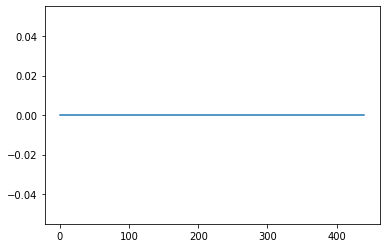

200


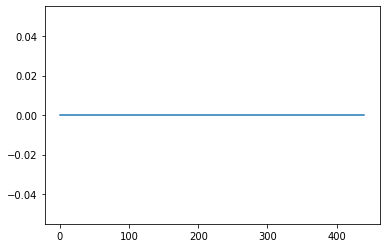

400


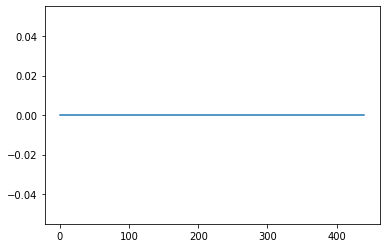

600


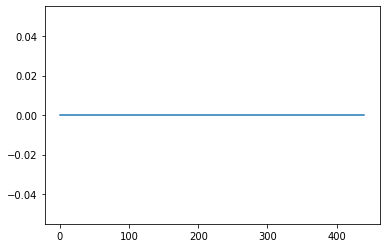

800


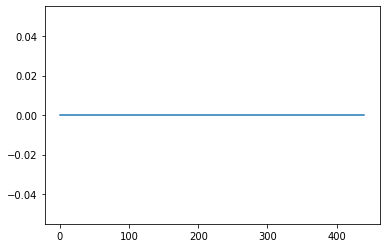

In [117]:
# %% debug plot
# for t in range(0, timesteps, int(timesteps/5)):
#     plot_3D(nx, ny, n[t, :])

x = np.arange(0, nx*ny, 1)
for t in range(0, timesteps, int(timesteps/5)):
    plt.plot(x, n[t, :])
    print(t)
    plt.show()

C:\Users\kikka\AppData\Local\Temp\ipykernel_31860\3504259423.py:119: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


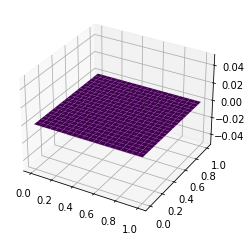

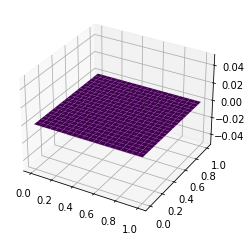

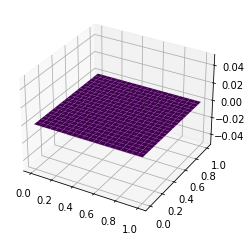

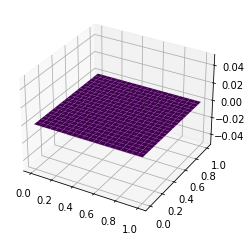

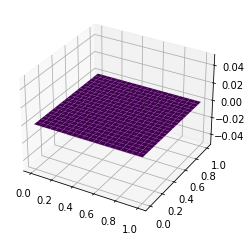

In [97]:
#%% Debug
for t in range(0, timesteps, int(timesteps/5)):
    plot_3D(nx, ny, r[t, :])


In [123]:
#%% sparse matrix evaluations
# Ainv = inv(A)
# AinvB = Ainv@B
# plt.spy(AinvB)
# plt.spy()
# zero = diags([0],[0], shape=(10,10)).toarray()
# print(zero)
# print(np.sum(A[0,:]))
# for i in range(A.shape[0]):
#     # if np.sum(A[i,:])>1.3:
#     #     print(i)
#     print(np.sum(A[i,:]))

# print(A.toarray())

# print(np.sum(r0))
# print(np.sum(r[0,:]))
# print(np.sum(r[5,:]))
# print(np.sum(r[10,:]))
# print(np.sum(r[20,:]))
# print(np.sum(r[500,:]))
# 1e-3*ma


def rowSum(a):
    pass
    l = a.shape[0]
    rs = np.zeros(l)
    ierror = []
    for i in range(l):
        if 0.9>np.sum(a[i,:]) or np.sum(a[i,:])>1.1:
            ierror.append(i)
    return ierror

aiErr = rowSum(A)
biErr = rowSum(B)
print(aiErr)
print(biErr)

[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 254, 255, 256, 257, 2